# Imports

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

# Data Preprocessing

In [2]:
root = "C:/Users/u144572/self_development/ml_method_kaggle/own_data"

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Get Respiratory Cycle length and Diagnosis

In [14]:
root = 'C:/Users/u144572/self_development/ml_method_kaggle/own_data/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]
filenames

import re
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model

def calculated_rr_and_predicted(file_name, root):
    respiratory_cycle_number = int(re.search(r'\d+', file_name).group())
    audio_length = librosa.get_duration(filename=f'{root}{file_name}.wav')
    rr = respiratory_cycle_number / (audio_length / 60)

    return pd.DataFrame(data = [[file_name, rr]], columns = ['patient_id', 'respiratory_rate'])

i_list = []
for s in filenames:
    (i) = calculated_rr_and_predicted(s, root)
    i_list.append(i)
rr_diagnosis_df = pd.concat(i_list, axis = 0)
rr_diagnosis_df

C:\Users\u144572\AppData\Local\Temp\ipykernel_35764\3788478833.py:16: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_length = librosa.get_duration(filename=f'{root}{file_name}.wav')


,patient_id,respiratory_rate
0,10,26.211556
0,11 normalnie,20.988806
0,12 normalnie,22.881356
0,6 glebokie,10.177925
0,6,12.881679
0,9,20.936725
0,gabi_13,29.485887
0,iza_10,21.502294
0,Janowska_6,19.852941
0,Janowska_9,16.707921


In [15]:
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [37]:
list(rr_diagnosis_df[rr_diagnosis_df["patient_id"]=="Janowska_6"]['respiratory_rate'])[0]

19.852941176470587

In [46]:
print("10.wav"[:-4])

10


In [49]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':
            label = list(data[data['patient_id']==soundDir[:-4]]['respiratory_rate'])[0]
                
            data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs)
            y_.append(list(data[data['patient_id']==soundDir[:-4]]['respiratory_rate'])[0])
            
            data_shift = shift(data_x,1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x,0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_noise)
            y_.append(label)
           
                
    X_data = np.array(X_)
    y_data = np.array(y_)    
    
    return X_data ,y_data

In [50]:
res_data, res_y = mfcc_feature_exteraction_rr(root)

In [51]:
res_features = np.array(res_data)
res_lables = np.array(res_y)

res_features.shape , res_lables.shape

((72, 50), (72,))

## Data Split

In [52]:
x_train, x_val, y_train, y_val  = train_test_split(res_features, res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)

print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(54, 50) (13, 50) (5, 50)
(54,) (13,) (5,)


# LSTM Model

In [53]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
x_test_lstm = np.expand_dims(x_test,axis=2)

## Build Model

In [54]:
# Define the model
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))

model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [56]:
history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=150, validation_data=(x_val_lstm, y_val),
  )
model.save("150_epochs_model_own_data.h5") 
model.save_weights('150_epochs_model_own_data.weights.h5')

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 385.6895 - mae: 18.8960 - val_loss: 433.9658 - val_mae: 20.1988
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 375.9126 - mae: 18.4286 - val_loss: 431.8039 - val_mae: 20.1461
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 352.1863 - mae: 17.9963 - val_loss: 422.3956 - val_mae: 19.9177
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 338.3297 - mae: 17.5816 - val_loss: 409.5486 - val_mae: 19.5943
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 319.0999 - mae: 16.9912 - val_loss: 392.1184 - val_mae: 19.1460
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 300.5804 - mae: 16.3608 - val_loss: 371.8661 - val_mae: 18.6104
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 262.8048 - mae: 14.9281 - val_loss: 349.0258 - val_mae: 17.9857
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 227.8811 - mae: 14.0298 - val_loss: 325.1588 - val_mae: 17.3091
Epoch 9/150
4/4 

## Evaluate Model

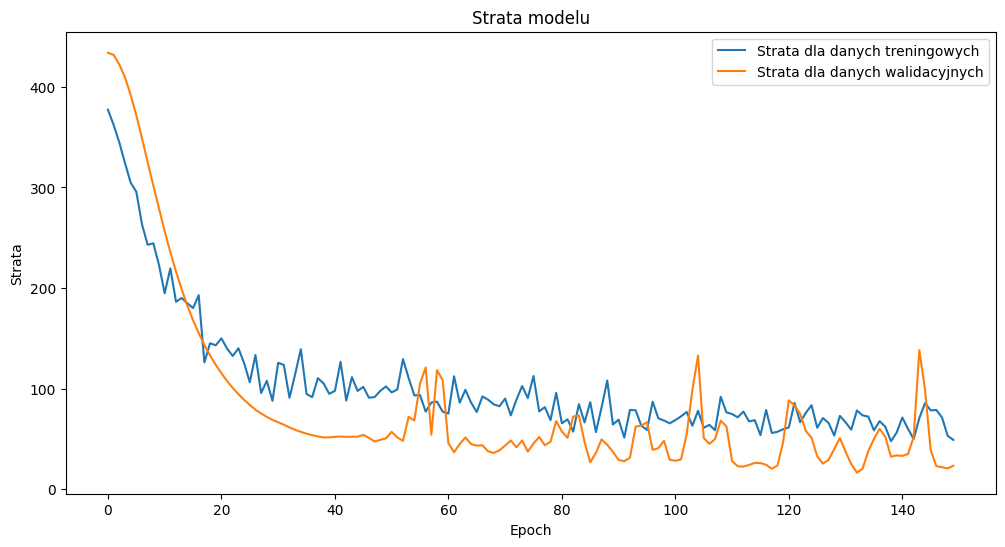

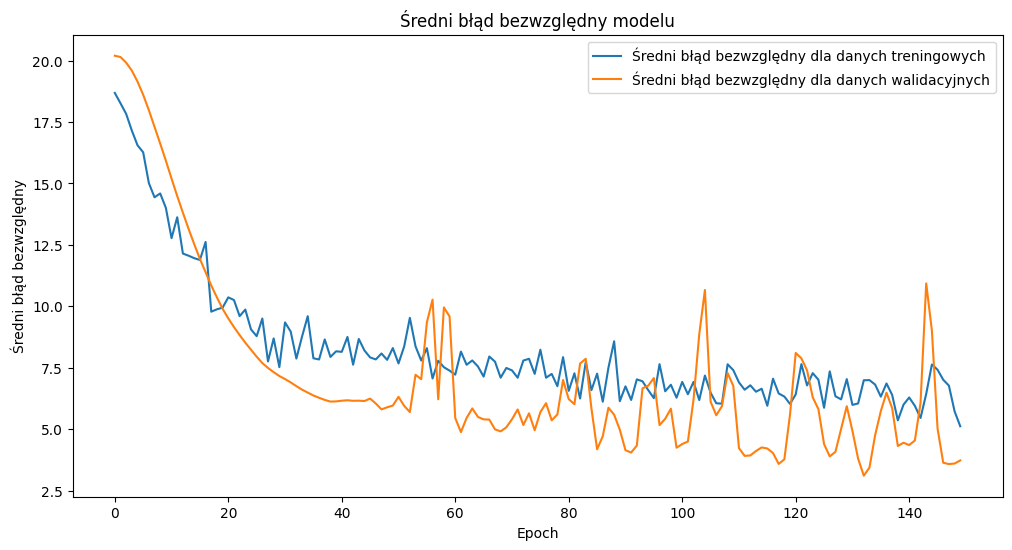

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


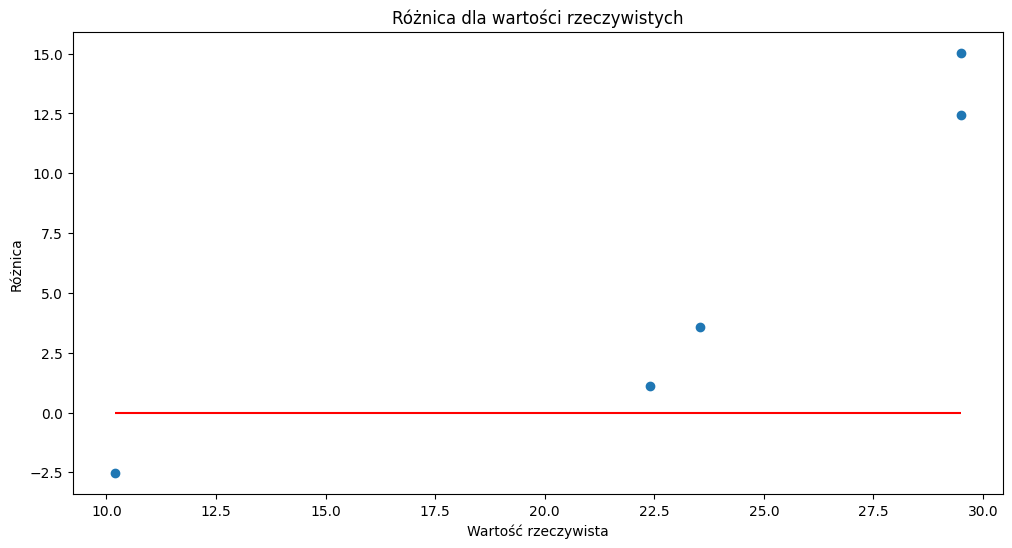

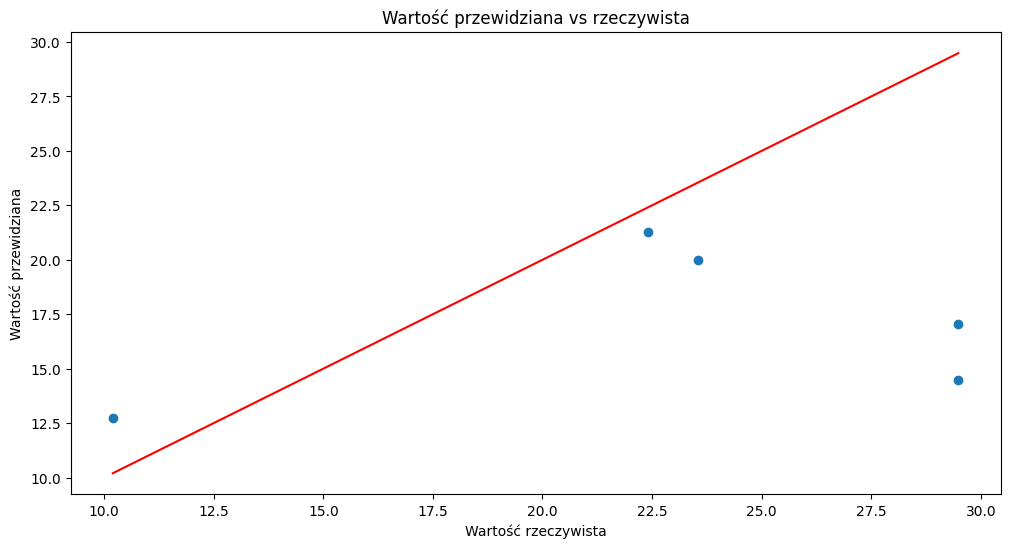

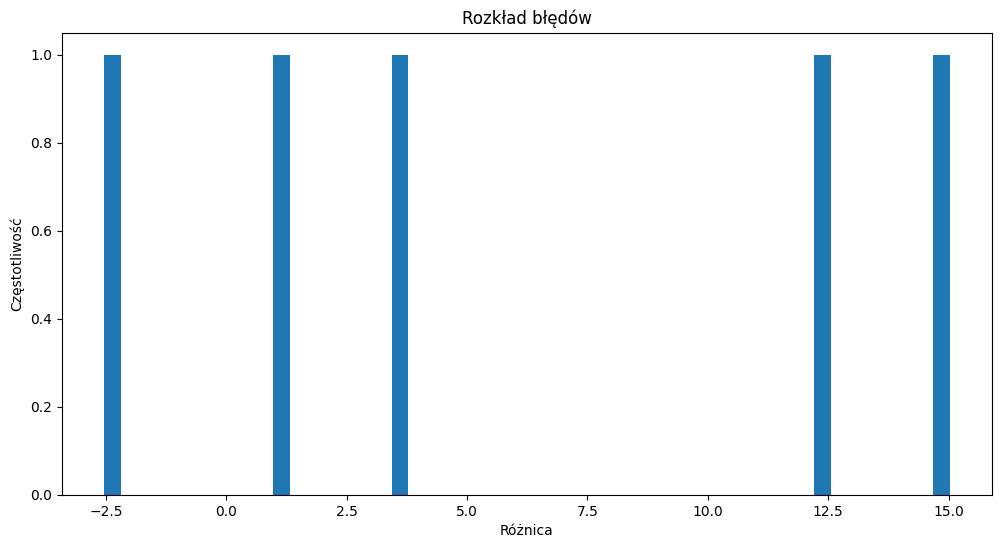

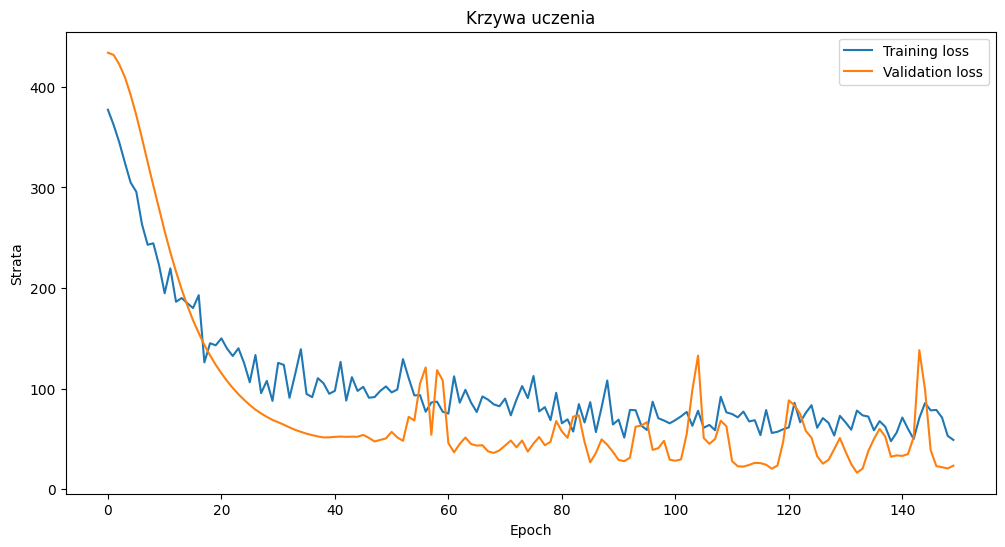

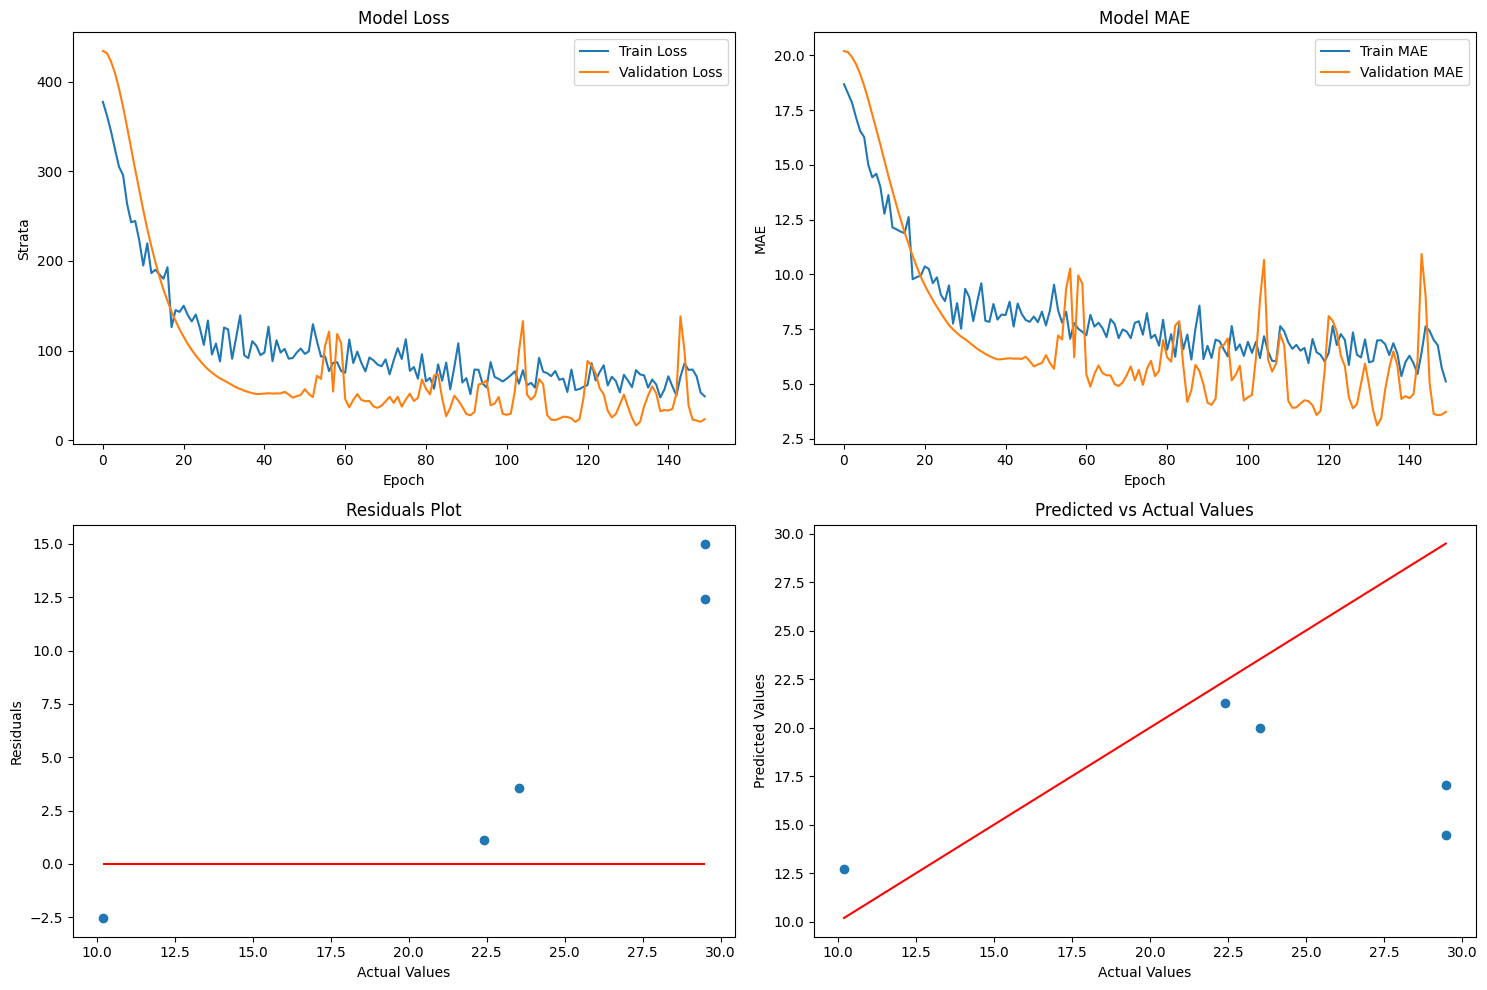

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Strata dla danych treningowych')
plt.plot(history.history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history.history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.show()

# Make predictions
y_pred = model.predict(x_test_lstm)

# Residuals Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r')
plt.title('Różnica dla wartości rzeczywistych')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Różnica')
plt.show()

# Predicted vs Actual Values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.title('Wartość przewidziana vs rzeczywista')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Wartość przewidziana')
plt.show()

# Error Distribution (Histogram of residuals)
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.title('Rozkład błędów')
plt.xlabel('Różnica')
plt.ylabel('Częstotliwość')
plt.show()

# Learning Curves: Train vs Validation loss over batches
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Krzywa uczenia')
    plt.xlabel('Epoch')
    plt.ylabel('Strata')
    plt.legend()
    plt.show()

plot_learning_curves(history)

# Function to create a single comprehensive plot
def plot_all_metrics(history, x_test_lstm, y_test, y_pred):
    # Training & validation loss
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Strata')
    plt.legend(loc='upper right')

    # Training & validation MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')

    # Residuals plot
    residuals = y_test - y_pred.flatten()
    plt.subplot(2, 2, 3)
    plt.scatter(y_test, residuals)
    plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r')
    plt.title('Residuals Plot')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    # Predicted vs Actual Values
    plt.subplot(2, 2, 4)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()

# Call the function to create the comprehensive plot
plot_all_metrics(history, x_test_lstm, y_test, y_pred)


In [91]:
loss, mae = model.evaluate(x_test_lstm, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 43.2983 - mae: 4.9917
Test Loss: 40.79694747924805
Test MAE: 4.819622993469238


In [1]:
import numpy as np
import librosa
from keras.models import load_model

def respiratory_rate_prediction(audio_path):
    # Load audio with 22050 Hz sampling rate
    # data_x, sampling_rate = librosa.load(audio_path, sr=22050)
    data_x, sampling_rate = librosa.load(audio_path, res_type='kaiser_fast')
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features)[0][0]

    print(f'Predicted Respiratory Rate: {predicted_value}')

respiratory_rate_prediction("C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav")

NameError: name 'model' is not defined

In [122]:
res_y[1]

34.5845487415067

In [123]:
rr_diagnosis_df

,patient_id,respiratory_rate
0,101,34.584549
1,102,39.593909
2,103,18.353301
3,104,26.274026
4,105,24.155805
...,...,...
121,222,12.113927
122,223,19.402063
123,224,21.060549
124,225,42.120042
